In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from matplotlib.ticker import MaxNLocator

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from google.colab import files
files.upload()
from general import distance, Responsibility, K_Means
from general import logTransform, plot_decomposition, test_stationarity

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Load the data

Merge train and test datasets

In [3]:
train = pd.read_csv("/content/drive/MyDrive/Enhance It/Training Projects/Time Series/train.csv")
train['Date'] = pd.to_datetime(train['Date'], dayfirst=False)
train

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [4]:
train = train.groupby(['Store','Date','IsHoliday']).agg('sum')
train

Dept  Weekly_Sales
Store Date       IsHoliday                    
1     2010-02-05 False      3184    1643690.90
      2010-02-12 True       3137    1641957.44
      2010-02-19 False      3184    1611968.17
      2010-02-26 False      3137    1409727.59
      2010-03-05 False      3215    1554806.68
...                          ...           ...
45    2012-09-28 False      2853     713173.95
      2012-10-05 False      2952     733455.07
      2012-10-12 False      2853     734464.36
      2012-10-19 False      2853     718125.53
      2012-10-26 False      2907     760281.43

[6435 rows x 2 columns]

In [5]:
# merged = pd.concat([train, test])

General Dataset with Train and test info

In [6]:
data = pd.read_csv("/content/drive/MyDrive/Enhance It/Training Projects/Time Series/Germán Eduardo Baltazar Reyes - walmart_features.csv")
data.drop('index', inplace = True, axis = 1)
data.drop('Unnamed: 0', inplace = True, axis = 1)
data['Date'] = pd.to_datetime(data['Date'], dayfirst=False)
data = train.merge(data, how='inner',on=['Date','Store'])
data['IsHoliday'] = data['IsHoliday'].astype(int)
data

,Date,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,2010-02-05,1,3184,1643690.90,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0
1,2010-02-12,1,3137,1641957.44,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1
2,2010-02-19,1,3184,1611968.17,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,0
3,2010-02-26,1,3137,1409727.59,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,0
4,2010-03-05,1,3215,1554806.68,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-09-28,45,2853,713173.95,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,0
6431,2012-10-05,45,2952,733455.07,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,0
6432,2012-10-12,45,2853,734464.36,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,0
6433,2012-10-19,45,2853,718125.53,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,0


In [7]:
print(f"Size of dataset: {data.shape}")
print(f"Number of duplicate rows in training: {data[data.duplicated()].shape}")

Size of dataset: (6435, 14)
Number of duplicate rows in training: (0, 14)


In [8]:
data.dtypes

Date            datetime64[ns]
Store                    int64
Dept                     int64
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                int64
dtype: object

##EDA and Data Cleaning

In [9]:
data.isna().sum()

Date               0
Store              0
Dept               0
Weekly_Sales       0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
dtype: int64

Get the unique values of Stores to see how many we have

In [10]:
stores = np.unique(data['Store'])
print(stores)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


Text(0.5, 1.0, 'Stores Fuel Price General Behavior')

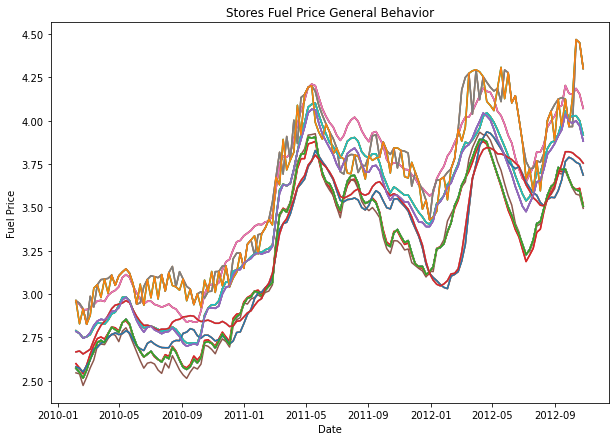

In [11]:
ys = []
x = data['Date'][data['Store']==1]
for i in stores:
  ys.append(data['Fuel_Price'][data['Store']==i])

plt.figure(figsize=(10,7))
plt.plot(x, ys[0])
plt.plot(x, ys[1])
plt.plot(x, ys[2])
plt.plot(x, ys[3])
plt.plot(x, ys[4])
plt.plot(x, ys[5])
plt.plot(x, ys[6])
plt.plot(x, ys[7])
plt.plot(x, ys[8])
plt.plot(x, ys[9])
plt.plot(x, ys[10])
plt.plot(x, ys[11])
plt.plot(x, ys[12])
plt.plot(x, ys[13])
plt.plot(x, ys[14])
plt.plot(x, ys[15])
plt.plot(x, ys[16])
plt.plot(x, ys[17])
plt.plot(x, ys[18])
plt.plot(x, ys[19])
plt.plot(x, ys[20])
plt.plot(x, ys[21])
plt.plot(x, ys[22])
plt.plot(x, ys[23])
plt.plot(x, ys[24])
plt.plot(x, ys[25])
plt.plot(x, ys[26])
plt.plot(x, ys[27])
plt.plot(x, ys[28])
plt.plot(x, ys[29])
plt.plot(x, ys[30])
plt.plot(x, ys[31])
plt.plot(x, ys[32])
plt.plot(x, ys[33])
plt.plot(x, ys[34])
plt.plot(x, ys[35])
plt.plot(x, ys[36])
plt.plot(x, ys[37])
plt.plot(x, ys[38])
plt.plot(x, ys[39])
plt.plot(x, ys[40])
plt.plot(x, ys[41])
plt.plot(x, ys[42])
plt.plot(x, ys[43])
plt.plot(x, ys[44])
plt.ylabel('Fuel Price')
plt.xlabel('Date')
plt.title('Stores Fuel Price General Behavior')

In [12]:
x = data['MarkDown1'][(pd.notna(data['MarkDown1'])) & (data['Store']==1)]

for i in stores:
  mk1 = data['MarkDown1'][(pd.notna(data['MarkDown1'])) & (data['Store']==i)]
  mn = np.median(mk1)
  data['MarkDown1'][(pd.isna(data['MarkDown1'])) & (data['Store']==i)] = mn

  mk2 = data['MarkDown2'][(pd.notna(data['MarkDown2'])) & (data['Store']==i)]
  mn = np.median(mk2)
  data['MarkDown2'][(pd.isna(data['MarkDown2'])) & (data['Store']==i)] = mn

  mk3 = data['MarkDown3'][(pd.notna(data['MarkDown3'])) & (data['Store']==i)]
  mn = np.median(mk3)
  data['MarkDown3'][(pd.isna(data['MarkDown3'])) & (data['Store']==i)] = mn

  mk4 = data['MarkDown4'][(pd.notna(data['MarkDown4'])) & (data['Store']==i)]
  mn = np.median(mk4)
  data['MarkDown4'][(pd.isna(data['MarkDown4'])) & (data['Store']==i)] = mn

  mk5 = data['MarkDown5'][(pd.notna(data['MarkDown5'])) & (data['Store']==i)]
  mn = np.median(mk5)
  data['MarkDown5'][(pd.isna(data['MarkDown5'])) & (data['Store']==i)] = mn

  cpi = data['CPI'][(pd.notna(data['CPI'])) & (data['Store']==i)]
  mn = np.median(cpi)
  data['CPI'][(pd.isna(data['CPI'])) & (data['Store']==i)] = mn

  unem = data['Unemployment'][(pd.notna(data['Unemployment'])) & (data['Store']==i)]
  mn = np.median(unem)
  data['Unemployment'][(pd.isna(data['Unemployment'])) & (data['Store']==i)] = mn

data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_laun

,Date,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,2010-02-05,1,3184,1643690.90,42.31,2.572,6154.14,144.87,25.965,1822.55,4325.19,211.096358,8.106,0
1,2010-02-12,1,3137,1641957.44,38.51,2.548,6154.14,144.87,25.965,1822.55,4325.19,211.242170,8.106,1
2,2010-02-19,1,3184,1611968.17,39.93,2.514,6154.14,144.87,25.965,1822.55,4325.19,211.289143,8.106,0
3,2010-02-26,1,3137,1409727.59,46.63,2.561,6154.14,144.87,25.965,1822.55,4325.19,211.319643,8.106,0
4,2010-03-05,1,3215,1554806.68,46.50,2.625,6154.14,144.87,25.965,1822.55,4325.19,211.350143,8.106,0


Text(0.5, 1.0, 'Stores CPI General Behavior')

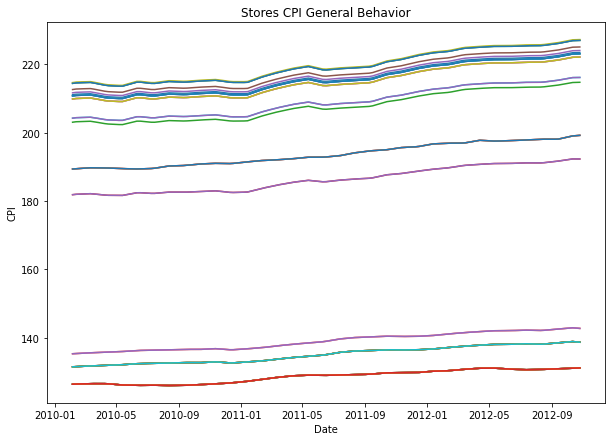

In [13]:
ys = []
x = data['Date'][data['Store']==1]
for i in stores:
  ys.append(data['CPI'][data['Store']==i])

plt.figure(figsize=(10,7))
plt.plot(x, ys[0])
plt.plot(x, ys[1])
plt.plot(x, ys[2])
plt.plot(x, ys[3])
plt.plot(x, ys[4])
plt.plot(x, ys[5])
plt.plot(x, ys[6])
plt.plot(x, ys[7])
plt.plot(x, ys[8])
plt.plot(x, ys[9])
plt.plot(x, ys[10])
plt.plot(x, ys[11])
plt.plot(x, ys[12])
plt.plot(x, ys[13])
plt.plot(x, ys[14])
plt.plot(x, ys[15])
plt.plot(x, ys[16])
plt.plot(x, ys[17])
plt.plot(x, ys[18])
plt.plot(x, ys[19])
plt.plot(x, ys[20])
plt.plot(x, ys[21])
plt.plot(x, ys[22])
plt.plot(x, ys[23])
plt.plot(x, ys[24])
plt.plot(x, ys[25])
plt.plot(x, ys[26])
plt.plot(x, ys[27])
plt.plot(x, ys[28])
plt.plot(x, ys[29])
plt.plot(x, ys[30])
plt.plot(x, ys[31])
plt.plot(x, ys[32])
plt.plot(x, ys[33])
plt.plot(x, ys[34])
plt.plot(x, ys[35])
plt.plot(x, ys[36])
plt.plot(x, ys[37])
plt.plot(x, ys[38])
plt.plot(x, ys[39])
plt.plot(x, ys[40])
plt.plot(x, ys[41])
plt.plot(x, ys[42])
plt.plot(x, ys[43])
plt.plot(x, ys[44])
plt.ylabel('CPI')
plt.xlabel('Date')
plt.title('Stores CPI General Behavior')

Text(0.5, 1.0, 'Stores Weekly Sales')

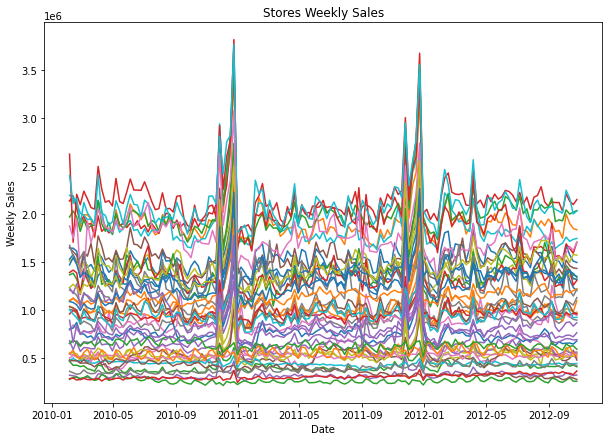

In [14]:
ys = []
x = data['Date'][data['Store']==1]
for i in stores:
  ys.append(data['Weekly_Sales'][data['Store']==i])

plt.figure(figsize=(10,7))
plt.plot(x, ys[0])
plt.plot(x, ys[1])
plt.plot(x, ys[2])
plt.plot(x, ys[3])
plt.plot(x, ys[4])
plt.plot(x, ys[5])
plt.plot(x, ys[6])
plt.plot(x, ys[7])
plt.plot(x, ys[8])
plt.plot(x, ys[9])
plt.plot(x, ys[10])
plt.plot(x, ys[11])
plt.plot(x, ys[12])
plt.plot(x, ys[13])
plt.plot(x, ys[14])
plt.plot(x, ys[15])
plt.plot(x, ys[16])
plt.plot(x, ys[17])
plt.plot(x, ys[18])
plt.plot(x, ys[19])
plt.plot(x, ys[20])
plt.plot(x, ys[21])
plt.plot(x, ys[22])
plt.plot(x, ys[23])
plt.plot(x, ys[24])
plt.plot(x, ys[25])
plt.plot(x, ys[26])
plt.plot(x, ys[27])
plt.plot(x, ys[28])
plt.plot(x, ys[29])
plt.plot(x, ys[30])
plt.plot(x, ys[31])
plt.plot(x, ys[32])
plt.plot(x, ys[33])
plt.plot(x, ys[34])
plt.plot(x, ys[35])
plt.plot(x, ys[36])
plt.plot(x, ys[37])
plt.plot(x, ys[38])
plt.plot(x, ys[39])
plt.plot(x, ys[40])
plt.plot(x, ys[41])
plt.plot(x, ys[42])
plt.plot(x, ys[43])
plt.plot(x, ys[44])
plt.ylabel('Weekly Sales')
plt.xlabel('Date')
plt.title('Stores Weekly Sales')

Substitute the NaN values of Markdown and CPI by the median value per store

##K-Means classification

Implement elbow method

In [15]:
def getWCSS(model,X,y_hat):
  wcss = 0

  for i in range(len(X)):
    dist2 = distance([X[i]], model.means[[y_hat[i]]])[0][0] ** 2
    wcss += dist2
  
  return wcss

In [16]:
X = data.loc[:][data['Weekly_Sales'].notna()]
X.drop('Date', inplace = True, axis = 1)
X = X.to_numpy().astype(float)

wcss = []
models = []
y_hats = []

for i in stores:
  print(f"Checking {i} of {stores[-1]}")
  model = K_Means(k=i)
  y_hat = model.fit(X)
  y_hats.append(y_hat)
  models.append(model)
  wcss.append(getWCSS(model,X,y_hat))

Checking 1 of 45
Checking 2 of 45
Checking 3 of 45
Checking 4 of 45
Checking 5 of 45
Checking 6 of 45
Checking 7 of 45
Checking 8 of 45
Checking 9 of 45
Checking 10 of 45
Checking 11 of 45
Checking 12 of 45
Checking 13 of 45
Checking 14 of 45
Checking 15 of 45
Checking 16 of 45
Checking 17 of 45
Checking 18 of 45
Checking 19 of 45
Checking 20 of 45
Checking 21 of 45
Checking 22 of 45
Checking 23 of 45
Checking 24 of 45
Checking 25 of 45
Checking 26 of 45
Checking 27 of 45
Checking 28 of 45
Checking 29 of 45
Checking 30 of 45
Checking 31 of 45
Checking 32 of 45
Checking 33 of 45
Checking 34 of 45
Checking 35 of 45
Checking 36 of 45
Checking 37 of 45
Checking 38 of 45
Checking 39 of 45
Checking 40 of 45
Checking 41 of 45
Checking 42 of 45
Checking 43 of 45
Checking 44 of 45
Checking 45 of 45


In [17]:
#Run after plotting
best = models[4]
y_hat = y_hats[4]

Text(0.5, 1.0, 'WCSS Comparison')

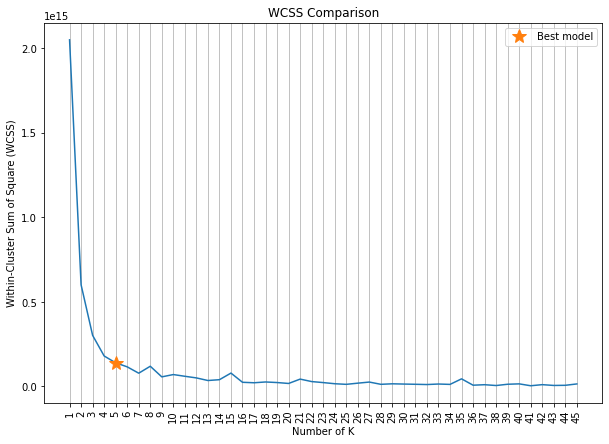

In [18]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(1,len(wcss)+1), wcss)
plt.plot(5,wcss[4], '*', markersize=15, label='Best model')
plt.legend()
plt.grid(axis='x', color='0.7')
plt.ylabel('Within-Cluster Sum of Square (WCSS)')
plt.xlabel('Number of K')
plt.xticks(np.arange(1,len(wcss)+1), rotation=90)
plt.title('WCSS Comparison')

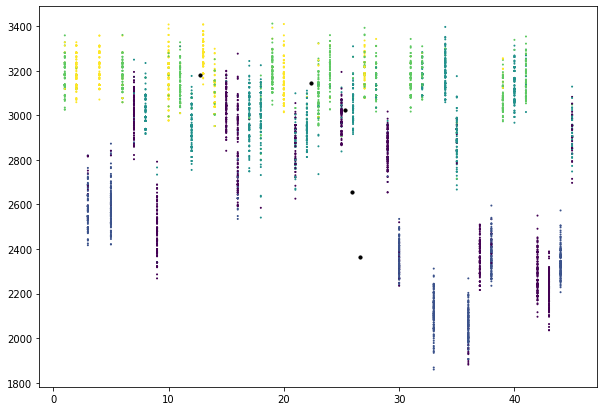

In [19]:
plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1],s=1,c=y_hat)
plt.scatter(best.means[:,0],best.means[:,1], c='k', s=10)

In [20]:
clusters = []
for i in range(len(data)):
  if i < len(y_hat):
    clusters.append(y_hat[i])
  else:
    clusters.append(np.NaN)

data['clusters'] = clusters
data

,Date,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,clusters
0,2010-02-05,1,3184,1643690.90,42.31,2.572,6154.14,144.87,25.965,1822.55,4325.19,211.096358,8.106,0,3
1,2010-02-12,1,3137,1641957.44,38.51,2.548,6154.14,144.87,25.965,1822.55,4325.19,211.242170,8.106,1,3
2,2010-02-19,1,3184,1611968.17,39.93,2.514,6154.14,144.87,25.965,1822.55,4325.19,211.289143,8.106,0,3
3,2010-02-26,1,3137,1409727.59,46.63,2.561,6154.14,144.87,25.965,1822.55,4325.19,211.319643,8.106,0,3
4,2010-03-05,1,3215,1554806.68,46.50,2.625,6154.14,144.87,25.965,1822.55,4325.19,211.350143,8.106,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-09-28,45,2853,713173.95,64.88,3.997,4556.61,20.64,1.500,1601.01,3288.25,192.013558,8.684,0,0
6431,2012-10-05,45,2952,733455.07,64.89,3.985,5046.74,187.59,18.820,2253.43,2340.01,192.170412,8.667,0,0
6432,2012-10-12,45,2853,734464.36,54.47,4.000,1956.28,187.59,7.890,599.32,3990.54,192.327265,8.667,0,0
6433,2012-10-19,45,2853,718125.53,56.47,3.969,2004.02,187.59,3.180,437.73,1537.49,192.330854,8.667,0,0


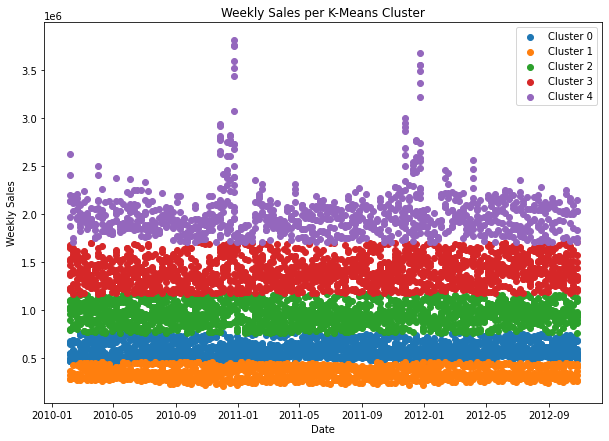

In [21]:
plt.figure(figsize=(10,7))
for i in range(5):
  plt.scatter(data['Date'][data['clusters']==i], data['Weekly_Sales'][data['clusters']==i], label=f"Cluster {i}")
plt.legend()
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.title("Weekly Sales per K-Means Cluster")
plt.show()

Get min, max, mean values of every feature for every class

In [22]:
cluster_params = dict()

for k in range(5):
  parameters = dict()
  parameters['minTemp'] = min(data['Temperature'][data['clusters']==k])
  parameters['maxTemp'] = max(data['Temperature'][data['clusters']==k])
  parameters['minFuel'] = min(data['Fuel_Price'][data['clusters']==k])
  parameters['maxFuel'] = max(data['Fuel_Price'][data['clusters']==k])
  parameters['minMk1'] = min(data['MarkDown1'][data['clusters']==k])
  parameters['maxMk1'] = max(data['MarkDown1'][data['clusters']==k])
  parameters['minMk2'] = min(data['MarkDown2'][data['clusters']==k])
  parameters['maxMk2'] = max(data['MarkDown2'][data['clusters']==k])
  parameters['minMk3'] = min(data['MarkDown3'][data['clusters']==k])
  parameters['maxMk3'] = max(data['MarkDown3'][data['clusters']==k])
  parameters['minMk4'] = min(data['MarkDown4'][data['clusters']==k])
  parameters['maxMk4'] = max(data['MarkDown4'][data['clusters']==k])
  parameters['minMk5'] = min(data['MarkDown5'][data['clusters']==k])
  parameters['maxMk5'] = max(data['MarkDown5'][data['clusters']==k])
  parameters['minCpi'] = min(data['CPI'][data['clusters']==k])
  parameters['maxCpi'] = max(data['CPI'][data['clusters']==k])
  parameters['minUnem'] = min(data['Unemployment'][data['clusters']==k])
  parameters['maxUnem'] = max(data['Unemployment'][data['clusters']==k])
  parameters['minSales'] = min(data['Weekly_Sales'][data['clusters']==k])
  parameters['maxSales'] = max(data['Weekly_Sales'][data['clusters']==k])

  cluster_params[f"Class {k}"] = parameters

print(cluster_params)

{'Class 0': {'minTemp': -2.06, 'maxTemp': 95.36, 'minFuel': 2.472, 'maxFuel': 4.468, 'minMk1': 1.5, 'maxMk1': 62567.6, 'minMk2': -9.98, 'maxMk2': 49913.53, 'minMk3': 0.01, 'maxMk3': 37612.74, 'minMk4': 2.52, 'maxMk4': 42448.94, 'minMk5': 135.16, 'maxMk5': 57029.78, 'minCpi': 126.064, 'maxCpi': 227.2328068, 'minUnem': 4.954, 'maxUnem': 12.187, 'minSales': 456140.34, 'maxSales': 757369.87}, 'Class 1': {'minTemp': 16.94, 'maxTemp': 100.14, 'minFuel': 2.513, 'maxFuel': 4.468, 'minMk1': 0.27, 'maxMk1': 23811.41, 'minMk2': -10.98, 'maxMk2': 17079.76, 'minMk3': -0.87, 'maxMk3': 658.01, 'minMk4': 0.22, 'maxMk4': 14928.42, 'minMk5': 153.9, 'maxMk5': 27754.23, 'minCpi': 126.064, 'maxCpi': 226.9873637, 'minUnem': 5.217, 'maxUnem': 14.313, 'minSales': 209986.25, 'maxSales': 455952.18}, 'Class 2': {'minTemp': 5.54, 'maxTemp': 99.22, 'minFuel': 2.514, 'maxFuel': 4.468, 'minMk1': 35.94, 'maxMk1': 88646.76, 'minMk2': -7.6, 'maxMk2': 58804.91, 'minMk3': 0.0, 'maxMk3': 67073.91, 'minMk4': 3.0, 'maxMk4':

Normalize the data with the min/max method of every class

In [23]:
for k in range(5):
  data['Temperature'][data['clusters']==k] = (data['Temperature'][data['clusters']==k]-data['Temperature'][data['clusters']==k].min()) / (data['Temperature'][data['clusters']==k].max()-data['Temperature'][data['clusters']==k].min())
  data['Fuel_Price'][data['clusters']==k] = (data['Fuel_Price'][data['clusters']==k]-data['Fuel_Price'][data['clusters']==k].min()) / (data['Fuel_Price'][data['clusters']==k].max()-data['Fuel_Price'][data['clusters']==k].min())
  data['MarkDown1'][data['clusters']==k] = (data['MarkDown1'][data['clusters']==k]-data['MarkDown1'][data['clusters']==k].min()) / (data['MarkDown1'][data['clusters']==k].max()-data['MarkDown1'][data['clusters']==k].min())
  data['MarkDown2'][data['clusters']==k] = (data['MarkDown2'][data['clusters']==k]-data['MarkDown2'][data['clusters']==k].min()) / (data['MarkDown2'][data['clusters']==k].max()-data['MarkDown2'][data['clusters']==k].min())
  data['MarkDown3'][data['clusters']==k] = (data['MarkDown3'][data['clusters']==k]-data['MarkDown3'][data['clusters']==k].min()) / (data['MarkDown3'][data['clusters']==k].max()-data['MarkDown3'][data['clusters']==k].min())
  data['MarkDown4'][data['clusters']==k] = (data['MarkDown4'][data['clusters']==k]-data['MarkDown4'][data['clusters']==k].min()) / (data['MarkDown4'][data['clusters']==k].max()-data['MarkDown4'][data['clusters']==k].min())
  data['MarkDown5'][data['clusters']==k] = (data['MarkDown5'][data['clusters']==k]-data['MarkDown5'][data['clusters']==k].min()) / (data['MarkDown5'][data['clusters']==k].max()-data['MarkDown5'][data['clusters']==k].min())
  data['CPI'][data['clusters']==k] = (data['CPI'][data['clusters']==k]-data['CPI'][data['clusters']==k].min()) / (data['CPI'][data['clusters']==k].max()-data['CPI'][data['clusters']==k].min())
  data['Unemployment'][data['clusters']==k] = (data['Unemployment'][data['clusters']==k]-data['Unemployment'][data['clusters']==k].min()) / (data['Unemployment'][data['clusters']==k].max()-data['Unemployment'][data['clusters']==k].min())
  data['Weekly_Sales'][data['clusters']==k] = (data['Weekly_Sales'][data['clusters']==k]-data['Weekly_Sales'][data['clusters']==k].min()) / (data['Weekly_Sales'][data['clusters']==k].max()-data['Weekly_Sales'][data['clusters']==k].min())

data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

,Date,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,clusters
0,2010-02-05,1,3184,0.887609,0.327782,0.029683,0.094195,0.004939,0.000766,0.026982,0.038344,0.842544,0.390754,0,3
1,2010-02-12,1,3137,0.884370,0.282896,0.017400,0.094195,0.004939,0.000766,0.026982,0.038344,0.843989,0.390754,1,3
2,2010-02-19,1,3184,0.828344,0.299669,0.000000,0.094195,0.004939,0.000766,0.026982,0.038344,0.844454,0.390754,0,3
3,2010-02-26,1,3137,0.450514,0.378809,0.024053,0.094195,0.004939,0.000766,0.026982,0.038344,0.844756,0.390754,0,3
4,2010-03-05,1,3215,0.721553,0.377274,0.056807,0.094195,0.004939,0.000766,0.026982,0.038344,0.845058,0.390754,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-09-28,45,2853,0.853282,0.687128,0.764028,0.072805,0.000613,0.000040,0.037659,0.055420,0.651876,0.515692,0,0
6431,2012-10-05,45,2952,0.920609,0.687231,0.758016,0.080639,0.003957,0.000500,0.053029,0.038753,0.653427,0.513342,0,0
6432,2012-10-12,45,2853,0.923960,0.580271,0.765531,0.031243,0.003957,0.000210,0.014060,0.067764,0.654977,0.513342,0,0
6433,2012-10-19,45,2853,0.869719,0.600801,0.750000,0.032006,0.003957,0.000084,0.010253,0.024648,0.655013,0.513342,0,0


In [24]:
data.drop('Dept', inplace = True, axis = 1)
data.drop('IsHoliday', inplace=True, axis=1)
data.drop('Store', inplace=True, axis=1)
data

,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,clusters
0,2010-02-05,0.887609,0.327782,0.029683,0.094195,0.004939,0.000766,0.026982,0.038344,0.842544,0.390754,3
1,2010-02-12,0.884370,0.282896,0.017400,0.094195,0.004939,0.000766,0.026982,0.038344,0.843989,0.390754,3
2,2010-02-19,0.828344,0.299669,0.000000,0.094195,0.004939,0.000766,0.026982,0.038344,0.844454,0.390754,3
3,2010-02-26,0.450514,0.378809,0.024053,0.094195,0.004939,0.000766,0.026982,0.038344,0.844756,0.390754,3
4,2010-03-05,0.721553,0.377274,0.056807,0.094195,0.004939,0.000766,0.026982,0.038344,0.845058,0.390754,3
...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-09-28,0.853282,0.687128,0.764028,0.072805,0.000613,0.000040,0.037659,0.055420,0.651876,0.515692,0
6431,2012-10-05,0.920609,0.687231,0.758016,0.080639,0.003957,0.000500,0.053029,0.038753,0.653427,0.513342,0
6432,2012-10-12,0.923960,0.580271,0.765531,0.031243,0.003957,0.000210,0.014060,0.067764,0.654977,0.513342,0
6433,2012-10-19,0.869719,0.600801,0.750000,0.032006,0.003957,0.000084,0.010253,0.024648,0.655013,0.513342,0


##CPI prediction

Get the mean value of each class per date into a particular dataset

In [25]:
dates = np.unique(data['Date'])
datasets = dict()

for k in range(5):
  dataset = pd.DataFrame(columns=['Date','Weekly_Sales','Temperature','Fuel_Price','MarkDown1','MarkDown2',
                                  'MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment'])
  for date in dates:
    temp = data[(data['clusters']==k) & (data['Date']==date)].mean()
    dataset = dataset.append({'Date':date, 'Weekly_Sales':temp[0], 'Temperature':temp[1], 'Fuel_Price':temp[2], 'MarkDown1':temp[3],
                              'MarkDown2':temp[4], 'MarkDown3':temp[5], 'MarkDown4':temp[6], 'MarkDown5':temp[7], 'CPI':temp[8],
                              'Unemployment':temp[9]}, ignore_index=True)
    
  datasets[f'Cluster {k}'] = dataset

print(f"Saved {len(datasets)} dataframes")
print(datasets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


Saved 5 dataframes
{'Cluster 0':           Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0   2010-02-05      0.287334     0.373546    0.099741   0.036227   0.003458   
1   2010-02-12      0.354944     0.371262    0.095858   0.041579   0.003711   
2   2010-02-19      0.290289     0.406721    0.079796   0.035651   0.003689   
3   2010-02-26      0.419168     0.412330    0.099783   0.053879   0.003794   
4   2010-03-05      0.368310     0.479368    0.112316   0.042023   0.003577   
..         ...           ...          ...         ...        ...        ...   
138 2012-09-28      0.359992     0.709337    0.691656   0.047896   0.001143   
139 2012-10-05      0.423114     0.696965    0.693387   0.046210   0.003463   
140 2012-10-12      0.434620     0.605560    0.702086   0.022327   0.003742   
141 2012-10-19      0.438498     0.632108    0.693387   0.017646   0.003742   
142 2012-10-26      0.350008     0.644857    0.643637   0.045411   0.000532   

     MarkDown3  Ma

In [31]:
# datasets['Cluster 3'] = datasets['Cluster 3'].dropna()
# datasets['Cluster 3'].reset_index()
datasets['Cluster 4'].isna().sum()

Date            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64

Get the parameter *d* for ARIMA

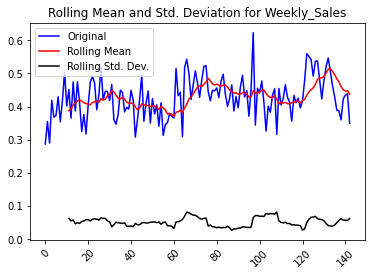

%%% Results %%%
Test Statistic             -3.570189
p_value                     0.006357
# Lags used                 5.000000
Number of Observations    137.000000
Critical Value(1%)         -3.479007
Critical Value(5%)         -2.882878
Critical Value(10%)        -2.578149
dtype: float64


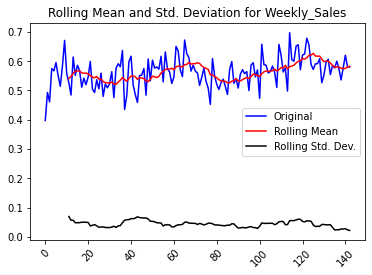

%%% Results %%%
Test Statistic             -2.433105
p_value                     0.132610
# Lags used                 9.000000
Number of Observations    133.000000
Critical Value(1%)         -3.480500
Critical Value(5%)         -2.883528
Critical Value(10%)        -2.578496
dtype: float64


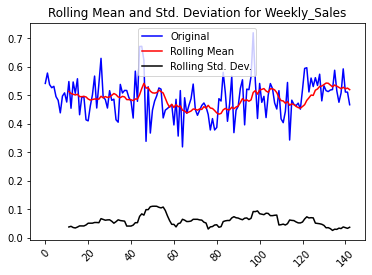

%%% Results %%%
Test Statistic           -6.147796e+00
p_value                   7.691654e-08
# Lags used               1.000000e+00
Number of Observations    1.410000e+02
Critical Value(1%)       -3.477601e+00
Critical Value(5%)       -2.882266e+00
Critical Value(10%)      -2.577822e+00
dtype: float64


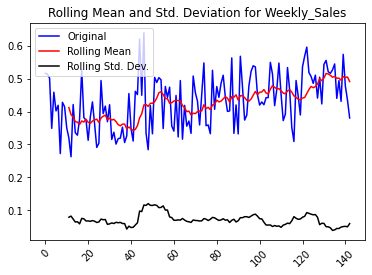

%%% Results %%%
Test Statistic             -2.729531
p_value                     0.069066
# Lags used                 6.000000
Number of Observations    136.000000
Critical Value(1%)         -3.479372
Critical Value(5%)         -2.883037
Critical Value(10%)        -2.578234
dtype: float64


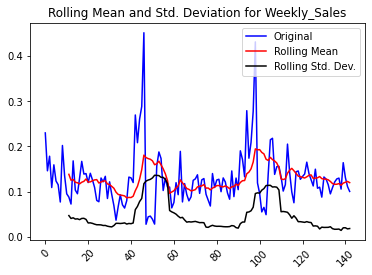

%%% Results %%%
Test Statistic           -6.150178e+00
p_value                   7.595733e-08
# Lags used               4.000000e+00
Number of Observations    1.380000e+02
Critical Value(1%)       -3.478648e+00
Critical Value(5%)       -2.882722e+00
Critical Value(10%)      -2.578065e+00
dtype: float64


In [32]:
test_stationarity(datasets['Cluster 0'], 'Weekly_Sales')
test_stationarity(datasets['Cluster 1'], 'Weekly_Sales')
test_stationarity(datasets['Cluster 2'], 'Weekly_Sales')
test_stationarity(datasets['Cluster 3'], 'Weekly_Sales')
test_stationarity(datasets['Cluster 4'], 'Weekly_Sales')

Make stationary the clusters that are not

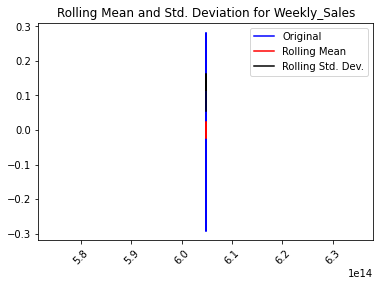

%%% Results %%%
Test Statistic           -9.731730e+00
p_value                   8.967131e-17
# Lags used               7.000000e+00
Number of Observations    1.330000e+02
Critical Value(1%)       -3.480500e+00
Critical Value(5%)       -2.883528e+00
Critical Value(10%)      -2.578496e+00
dtype: float64


In [64]:
datasets['Cluster 1']=datasets['Cluster 1'].set_index('Date')
datasets['Cluster 1'] = datasets['Cluster 1'].diff().dropna()
test_stationarity(datasets['Cluster 1'], 'Weekly_Sales')

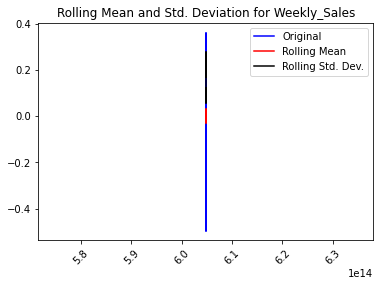

%%% Results %%%
Test Statistic           -6.615380e+00
p_value                   6.226357e-09
# Lags used               1.300000e+01
Number of Observations    1.270000e+02
Critical Value(1%)       -3.482920e+00
Critical Value(5%)       -2.884580e+00
Critical Value(10%)      -2.579058e+00
dtype: float64


In [63]:
datasets['Cluster 3'] = datasets['Cluster 3'].set_index('Date')
datasets['Cluster 3'] = datasets['Cluster 3'].diff().dropna()
test_stationarity(datasets['Cluster 3'], 'Weekly_Sales')

In [35]:
d = [0, 1, 0, 1, 0]

Get the parameter *p* for ARIMA

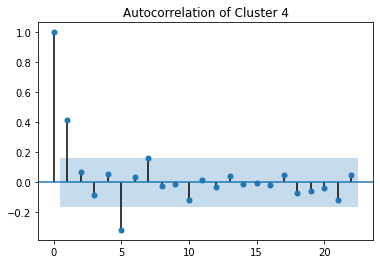

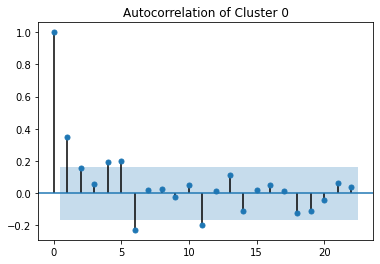

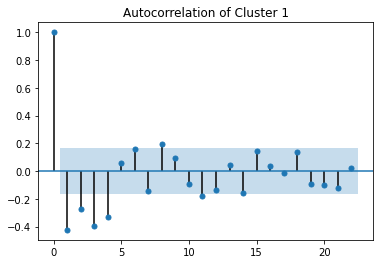

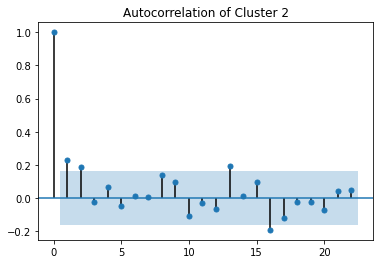

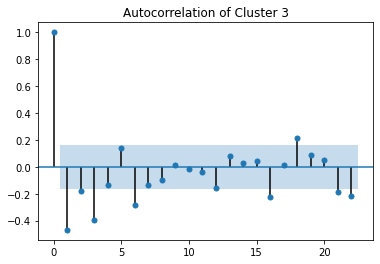

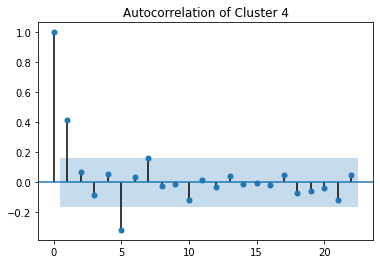

In [36]:
plot_pacf(datasets['Cluster 0']['Weekly_Sales'], title='Autocorrelation of Cluster 0')  #p=1
plot_pacf(datasets['Cluster 1']['Weekly_Sales'], title='Autocorrelation of Cluster 1')  #p=1
plot_pacf(datasets['Cluster 2']['Weekly_Sales'], title='Autocorrelation of Cluster 2')  #p=1
plot_pacf(datasets['Cluster 3']['Weekly_Sales'], title='Autocorrelation of Cluster 3')  #p=1
plot_pacf(datasets['Cluster 4']['Weekly_Sales'], title='Autocorrelation of Cluster 4')  #p=1

In [37]:
p = np.ones(5)

Get the parameterh *q* for ARIMA

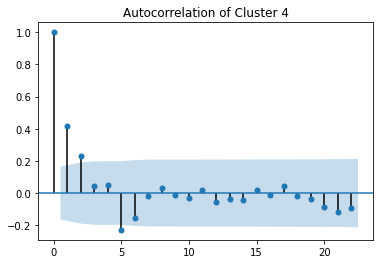

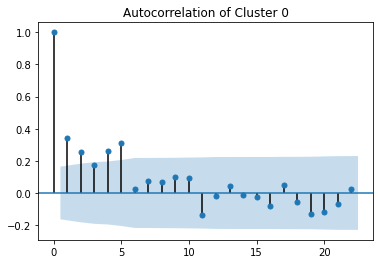

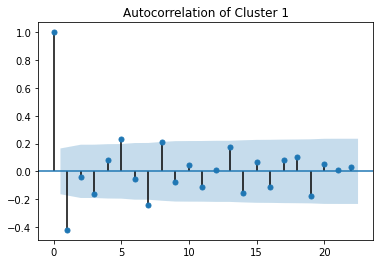

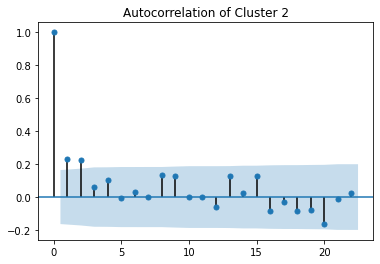

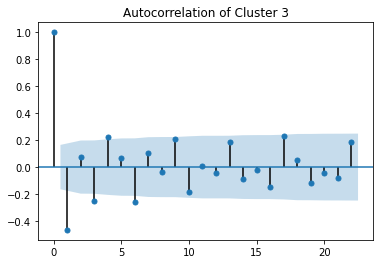

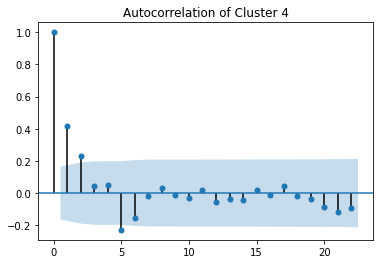

In [38]:
plot_acf(datasets['Cluster 0']['Weekly_Sales'], title='Autocorrelation of Cluster 0')  #q=2
plot_acf(datasets['Cluster 1']['Weekly_Sales'], title='Autocorrelation of Cluster 1')  #q=1
plot_acf(datasets['Cluster 2']['Weekly_Sales'], title='Autocorrelation of Cluster 2')  #q=1
plot_acf(datasets['Cluster 3']['Weekly_Sales'], title='Autocorrelation of Cluster 3')  #q=3
plot_acf(datasets['Cluster 4']['Weekly_Sales'], title='Autocorrelation of Cluster 4')  #q=2

In [39]:
q = [2,1,1,3,2]

Get the time-series

In [40]:
def runExArima(data, ts, exo, p, d, q):
  model = ARIMA(data[ts], exog=data[exo], order=(p,d,q))
  results = model.fit(disp=-1)

  len_res = len(results.fittedvalues)
  ts_modified = data[ts][-len_res:]

  rss = sum((results.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss/len(data[ts]))
  print(f"RMSE: {rmse}")

  plt.figure(figsize=(10,7))
  plt.plot(data[ts])
  plt.plot(results.fittedvalues, color='red')
  plt.show()

  return results

In [59]:
X = datasets['Cluster 0'].copy()
Y = X['Weekly_Sales']
Y = Y.to_numpy()
X.drop(['Date','Weekly_Sales'], inplace=True, axis=1)
exo = X.to_numpy()

model = ARIMA(Y, exog=exo, order=(p[0],d[0],q[0]))
fitted = model.fit(disp=-1)

TypeError: ignored

In [60]:
datasets['Cluster 0']

,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,2010-02-05,0.287334,0.373546,0.099741,0.036227,0.003458,0.000244,0.012264,0.028860,0.594999,0.480518
1,2010-02-12,0.354944,0.371262,0.095858,0.041579,0.003711,0.000284,0.014775,0.031811,0.569261,0.499228
2,2010-02-19,0.290289,0.406721,0.079796,0.035651,0.003689,0.000258,0.012235,0.030219,0.571260,0.493860
3,2010-02-26,0.419168,0.412330,0.099783,0.053879,0.003794,0.000303,0.019801,0.035655,0.518966,0.490921
4,2010-03-05,0.368310,0.479368,0.112316,0.042023,0.003577,0.000238,0.014945,0.032507,0.591233,0.510011
...,...,...,...,...,...,...,...,...,...,...,...
138,2012-09-28,0.359992,0.709337,0.691656,0.047896,0.001143,0.000169,0.015127,0.046018,0.639875,0.351105
139,2012-10-05,0.423114,0.696965,0.693387,0.046210,0.003463,0.000241,0.033395,0.039063,0.592164,0.350154
140,2012-10-12,0.434620,0.605560,0.702086,0.022327,0.003742,0.000239,0.010354,0.040030,0.643112,0.316064
141,2012-10-19,0.438498,0.632108,0.693387,0.017646,0.003742,0.000170,0.004771,0.043400,0.643369,0.316064


##Working with the Test Set

Use the data to determine to which class the observation belongs to.

After that, use the corresponding trained model for predicting

In [61]:
test = pd.read_csv("/content/drive/MyDrive/Enhance It/Training Projects/Time Series/test.csv")
test['Date'] = pd.to_datetime(test['Date'], dayfirst=False)
test

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [ ]:
test = test.groupby(['Store','Date','IsHoliday']).agg('sum')
test